<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/Trained_model/Applying_trained_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Applying the training neural netowrk on new data

In [ ]:
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd
import numpy as np 

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb

from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize 
from matplotlib import cm
import io

from random import randint
from sklearn.utils import shuffle
from google.colab import drive
from numpy.random import seed
from tensorflow.keras.models import load_model


def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])


def MinMaxTransformTrain(dataset_train, points):

  max_rho=[]
  min_rho=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))
  
  # Change the range of rho from 0 to 1
  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_train)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=(NewValue)
    else:
        NewValue = (dataset_train.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T

  return df_rho


def MinMaxTransformTest(dataset_test, dataset_train, points):

  max_rho=[]
  min_rho=[]
  for i in range(len(dataset_train)):
    max_rho.append(max(dataset_train.iloc[i, 0:points].values))
    min_rho.append(min(dataset_train.iloc[i, 0:points].values))

  # Change the range of rho from 0 to 1

  OldMax= max(max_rho)
  OldMin=min(min_rho)

  NewValues_rho={}

  OldRange = abs(OldMax - OldMin)
  for i in range(len(dataset_test)):
    if (OldRange == 0):
        NewValue = OldMin
        NewValues_rho[i]=NewValue
    else:
        NewValue = (dataset_test.iloc[i, 0:points] - OldMin)/(OldMax-OldMin) 
        NewValues_rho[i]=NewValue

  df_rho=pd.DataFrame.from_dict(NewValues_rho).T


  return df_rho


def density_scatter(x, y, title=None, label=None, colours='magma_r', lim1=10, lim2=80, eq_sq=True, figsize=(8,8)):
  # Calculate the point density
  x=np.asarray(x)
  y=np.asarray(y)
  xy = np.vstack([x, y])
  z = gaussian_kde(xy)(xy)
  # Sort the points by density, so that the densest points are plotted last
  idx = z.argsort()
  x, y, z = x[idx], y[idx], z[idx]

  fig, ax = plt.subplots(figsize=figsize)
  ax.set_facecolor('whitesmoke')
  if title!=None:
    plt.title(title)
  im=ax.scatter(x, y, label=label, c=z, s=50, cmap=colours)
  plt.xlabel('True Values of ST (mN/m)')
  plt.ylabel('Predictions of ST (mN/m)')
  if eq_sq==True:
    plt.axis('equal')
    plt.axis('square')
  # plt.xlim([lim1, lim2])
  # plt.ylim([lim1, lim2])
  norm = Normalize(vmin = np.min(z), vmax = np.max(z))
  cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=colours), ax=ax)
  cbar.ax.set_ylabel('Density')


### Connect to google drive

#### **If** the required files are on google drive, run this code to connect to the google drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Import and visualize training dataset for normalization

#### **First**: Upload the training dataset, test dataset and the file containing the trained neural network, to the files folder or define the path to those files in google drive.  

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,phi_173,phi_174,volume,Aspect_Ratio,volt,current,centred_z,surfactant_conc,ST,surf_number
46690,0.817458,0.819281,0.818349,0.816758,0.815800,0.814156,0.813548,0.810016,0.807470,0.805922,...,3.098966,3.135,1.951601,1.165761,6.68,0.277,-0.156383,1.405932,38.186800,1.0
46691,0.734421,0.735177,0.733054,0.731874,0.731637,0.729771,0.730118,0.728796,0.724406,0.722571,...,3.098966,3.135,1.417612,1.167173,6.77,0.281,-0.111630,0.607334,29.319754,2.0
46692,0.676648,0.678312,0.677033,0.676624,0.677098,0.674553,0.672849,0.671993,0.670308,0.668801,...,3.098966,3.135,1.128066,1.145161,7.22,0.296,-0.103432,0.422297,29.731824,2.0
46693,0.762581,0.764566,0.763723,0.763867,0.761130,0.759349,0.758532,0.756957,0.755439,0.753855,...,3.098966,3.135,1.607457,1.146132,6.60,0.276,-0.118464,0.229848,34.512111,2.0
46694,0.716716,0.715276,0.715206,0.713379,0.714116,0.711889,0.708105,0.706136,0.702770,0.700117,...,3.098966,3.135,1.247519,1.224756,7.68,0.304,0.049059,0.296165,31.692066,2.0


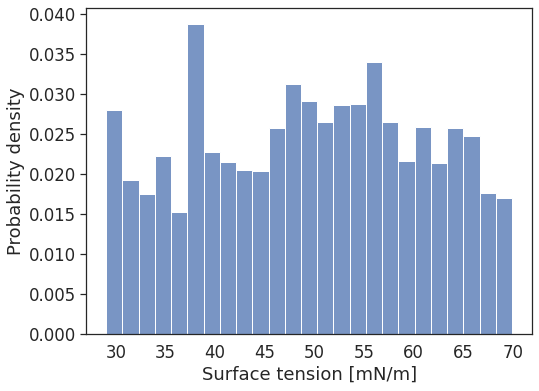

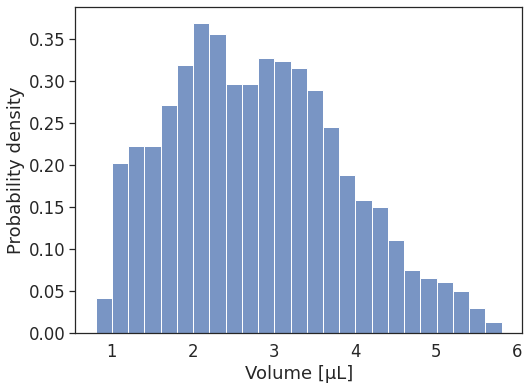

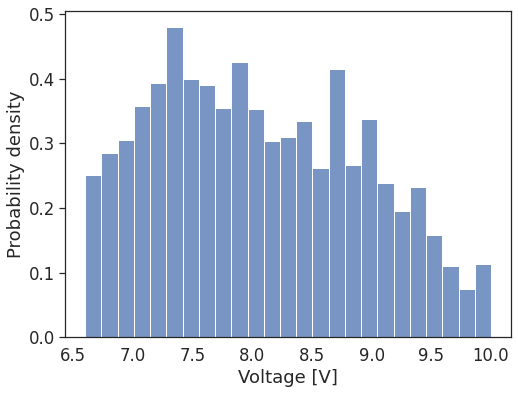

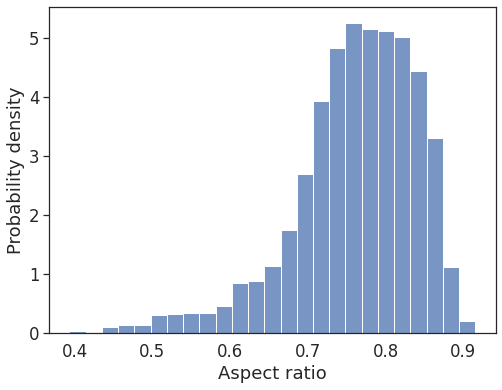

In [ ]:
sns.set_theme(style='ticks', font_scale=1.5)


# path_files=str('/content/drive/My Drive/DropLev/for_draft/Experimental/Raw_data/')
# os.chdir(path_files)
# training_dataset=pd.read_csv(str(path_files+'training_dataset_for_normalization.csv'), sep="\t", header=None)

training_dataset=pd.read_csv(str('training_dataset_pre_norm.csv'),  header=0, sep=';')
training_dataset.pop('Unnamed: 0')



### Plot data distribution
plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(training_dataset.loc[:, 'ST'], kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(training_dataset.loc[:, 'volume'], kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)


plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(training_dataset.loc[:, 'volt'], kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)



plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(1/training_dataset.loc[:, 'Aspect_Ratio'], kde=False, bins=25, stat="density")
plt.xlabel('Aspect ratio')
plt.tick_params(bottom = False)


### Print the öast 5 rows of the training dataset
training_dataset.tail()





In [ ]:
### Remove the columns we don't use, but save the values as variables
volume_train=training_dataset.pop('volume')
Aspect_Ratio_train=training_dataset.pop('Aspect_Ratio')
surf_conc_train=training_dataset.pop('surfactant_conc')
surf_number_train=training_dataset.pop('surf_number')

### Print the statistics of the training dataset
points=175
if training_dataset.shape[1]>2*points:
  stats = training_dataset.iloc[:, 2*points:].describe() 
else:
  stats = training_dataset.iloc[:, points:].describe() 
# stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
volt,46695.0,8.063710,0.857414,6.600000,7.340000,7.970000,8.750000,10.000000
current,46695.0,0.312764,0.019648,0.272000,0.296000,0.312000,0.329000,0.366000
centred_z,46695.0,0.001997,0.094150,-0.323581,-0.069027,0.020304,0.080019,0.244943
ST,46695.0,49.504606,11.279460,29.024210,39.751155,49.820528,58.573276,69.925068


### Normalize the training dataset

In [ ]:

new_df_train=MinMaxTransformTrain(dataset_train=training_dataset, points=175)
new_df_train.tail()


if training_dataset.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(training_dataset.iloc[:, 2*points:])
  normed_test_data_rest = min_max_norm(training_dataset.iloc[:, 2*points:])   
else:
  normed_train_data_rest = min_max_norm(training_dataset.iloc[:, points:])
  normed_test_data_rest = min_max_norm(training_dataset.iloc[:, points:])   

normed_train_data = new_df_train.copy()

normed_train_data['centred_z'] = normed_train_data_rest.centred_z
normed_train_data['volt'] = normed_train_data_rest.volt
normed_train_data['current'] = normed_train_data_rest.current
normed_train_data['ST'] = normed_train_data_rest.ST

normed_train_data.tail()



,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174,centred_z,volt,current,ST
46690,0.426971,0.429182,0.428052,0.426121,0.424959,0.422964,0.422226,0.417940,0.414851,0.412972,...,0.418530,0.423149,0.424376,0.426875,0.426036,0.426485,0.294091,0.023529,0.053191,0.224020
46691,0.326212,0.327130,0.324554,0.323121,0.322835,0.320570,0.320992,0.319387,0.314060,0.311834,...,0.317665,0.321776,0.322317,0.324001,0.326828,0.326163,0.372809,0.050000,0.095745,0.007226
46692,0.256110,0.258129,0.256577,0.256080,0.256656,0.253568,0.251500,0.250461,0.248417,0.246588,...,0.249586,0.250541,0.252546,0.255598,0.255086,0.255643,0.387228,0.182353,0.255319,0.017301
46693,0.360382,0.362791,0.361767,0.361943,0.358621,0.356460,0.355469,0.353558,0.351716,0.349794,...,0.354084,0.354698,0.356498,0.359485,0.359045,0.359804,0.360788,0.000000,0.042553,0.134176
46694,0.304729,0.302982,0.302896,0.300680,0.301574,0.298872,0.294281,0.291891,0.287807,0.284587,...,0.293792,0.299228,0.301109,0.304101,0.303596,0.304220,0.655452,0.317647,0.340426,0.065227


### Import and visualize the new data

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,phi_173,phi_174,volume,Aspect_Ratio,volt,current,centred_z,surfactant_conc,ST,surf_number
11669,0.750082,0.747623,0.749971,0.747738,0.746021,0.743519,0.741955,0.739820,0.737640,0.734385,...,3.098966,3.135,1.439373,1.217391,8.03,0.319,-0.041790,1.287874,29.029438,2.0
11670,0.748133,0.749463,0.747931,0.747362,0.745747,0.745237,0.743263,0.739016,0.738643,0.734893,...,3.098966,3.135,1.431500,1.218069,8.03,0.319,-0.032228,1.294957,29.028647,2.0
11671,0.753840,0.753374,0.753588,0.751085,0.749518,0.746964,0.745349,0.742554,0.737659,0.734028,...,3.098966,3.135,1.429341,1.242902,8.11,0.321,-0.001628,1.296913,29.028430,2.0
11672,0.746014,0.747059,0.745238,0.744376,0.744479,0.741654,0.738472,0.734822,0.733466,0.729509,...,3.098966,3.135,1.404004,1.234177,8.18,0.321,0.057657,1.320317,29.025851,2.0
11673,0.752065,0.749684,0.748268,0.747816,0.745170,0.743552,0.740508,0.737160,0.735552,0.729464,...,3.098966,3.135,1.393231,1.267742,8.33,0.327,0.042358,1.330526,29.024740,2.0


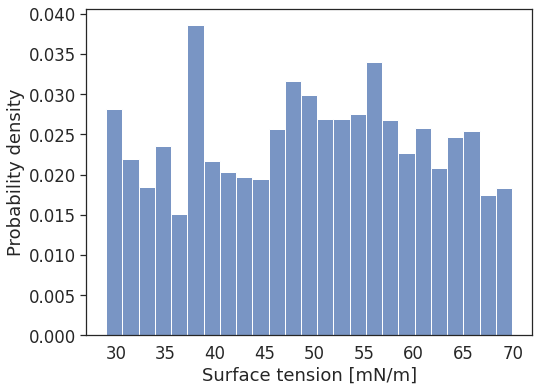

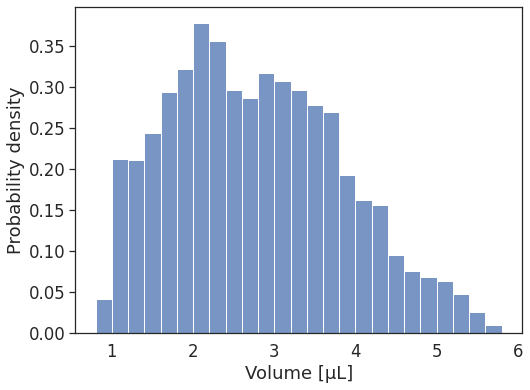

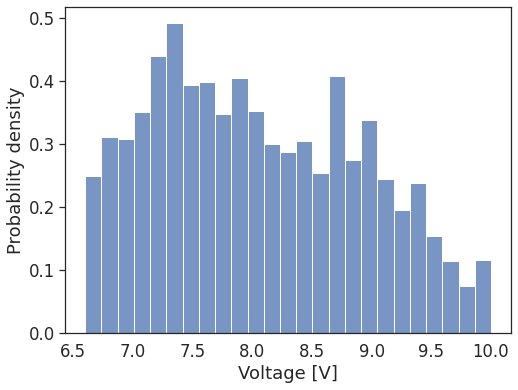

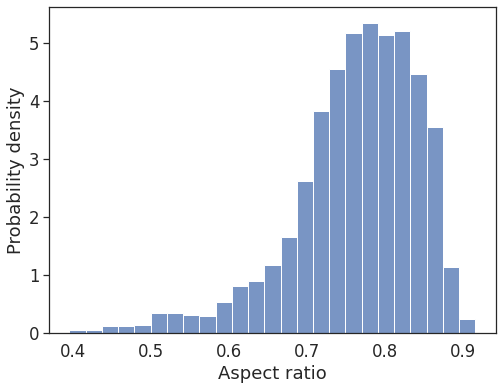

In [ ]:
### Import test dataset
test_dataset=pd.read_csv(str('test_dataset.csv'), header=0,  sep=";")
test_dataset.pop('Unnamed: 0')

### Plot data distribution

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_dataset.loc[:, 'ST'], kde=False, bins=25, stat="density")
plt.xlabel('Surface tension [mN/m]')
plt.tick_params(bottom = False)

plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_dataset.loc[:, 'volume'], kde=False, bins=25, stat="density")
plt.xlabel('Volume [μL]')
plt.tick_params(bottom = False)


plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(test_dataset.loc[:, 'volt'], kde=False, bins=25, stat="density")
plt.xlabel('Voltage [V]')
plt.tick_params(bottom = False)



plt.figure(figsize=(8,6))
plt.ylabel('Probability density')
sns.histplot(1/test_dataset.loc[:, 'Aspect_Ratio'], kde=False, bins=25, stat="density")
plt.xlabel('Aspect ratio')
plt.tick_params(bottom = False)

test_dataset.tail()



### Normalize the test dataset based on the training dataset

In [ ]:
### Normalize the test dataset based on training dataset 

new_df_test=MinMaxTransformTest(test_dataset, training_dataset, points=175)

# new_df_test.tail()


if training_dataset.shape[1]>2*points:
  normed_train_data_rest = min_max_norm(training_dataset.iloc[:, 2*points:]) 
  normed_test_data_rest = min_max_norm(test_dataset.iloc[:, 2*points:])   
else:
  normed_train_data_rest = min_max_norm(training_dataset.iloc[:, points:]) 
  normed_test_data_rest = min_max_norm(test_dataset.iloc[:, points:])   


#Putting scalled test dataset together

normed_test_data = new_df_test.copy()

normed_test_data['centred_z'] = normed_test_data_rest.centred_z
normed_test_data['volt'] = normed_test_data_rest.volt
normed_test_data['current'] = normed_test_data_rest.current
normed_test_data['ST'] = normed_test_data_rest.ST

normed_test_data.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,...,rho_169,rho_170,rho_171,rho_172,rho_173,rho_174,centred_z,volt,current,ST
11669,0.345216,0.342232,0.345081,0.342371,0.340288,0.337253,0.335354,0.332764,0.330118,0.326168,...,0.333311,0.337798,0.338985,0.341335,0.344850,0.344900,0.495654,0.420588,0.500000,0.000128
11670,0.342850,0.344464,0.342605,0.341915,0.339956,0.339336,0.336941,0.331789,0.331336,0.326785,...,0.335649,0.340201,0.341435,0.343730,0.342551,0.342553,0.512473,0.420588,0.500000,0.000108
11671,0.349775,0.349210,0.349470,0.346433,0.344531,0.341433,0.339472,0.336080,0.330142,0.325736,...,0.338212,0.342813,0.343885,0.346127,0.349540,0.349494,0.566296,0.444118,0.521277,0.000103
11672,0.340280,0.341547,0.339338,0.338292,0.338417,0.334989,0.331128,0.326699,0.325053,0.320253,...,0.330176,0.334535,0.337623,0.337320,0.340453,0.340113,0.670576,0.464706,0.521277,0.000040
11673,0.347622,0.344733,0.343014,0.342467,0.339255,0.337292,0.333599,0.329535,0.327585,0.320198,...,0.335028,0.339826,0.341095,0.343529,0.347133,0.347276,0.643665,0.508824,0.585106,0.000013


### Remove the surface tension from the datasets

In [ ]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

### Load model

In [ ]:
path=str('/content/drive/My Drive/DropLev/for_draft/Experimental/')
date=20220329
surf='SDS_CTAB_TX100'
training=1
MAE='088'

filename=str(path+'Model_saved_%s_train_%d_MAE_%s_%d_final.h5' %(surf, training, MAE, date))

model=load_model(filename)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                8950      
                                                                 
 dense_9 (Dense)             (None, 40)                2040      
                                                                 
 dense_10 (Dense)            (None, 30)                1230      
                                                                 
 dense_11 (Dense)            (None, 20)                620       
                                                                 
 dense_12 (Dense)            (None, 15)                315       
                                                                 
 dense_13 (Dense)            (None, 10)                160       
                                                                 
 dense_14 (Dense)            (None, 5)                

### Visualize the predictions

1460/1460 [==============================] - 2s 1ms/step


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

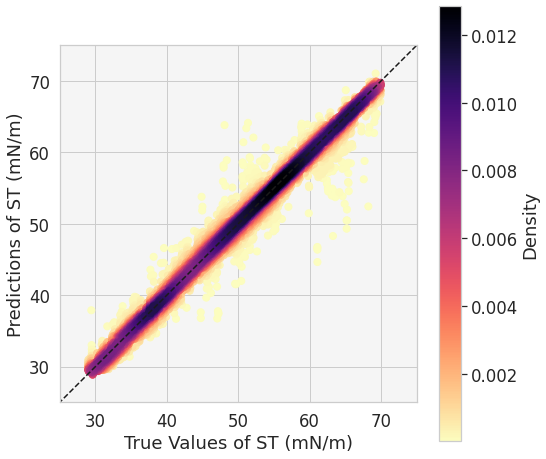

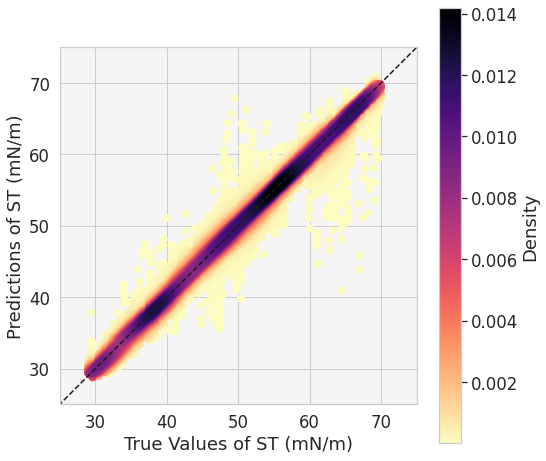

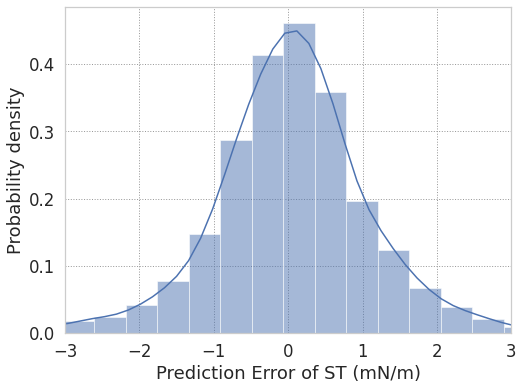

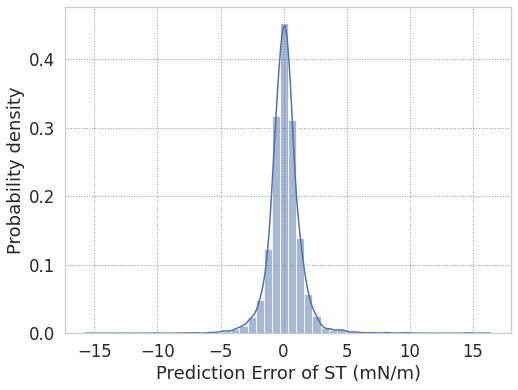

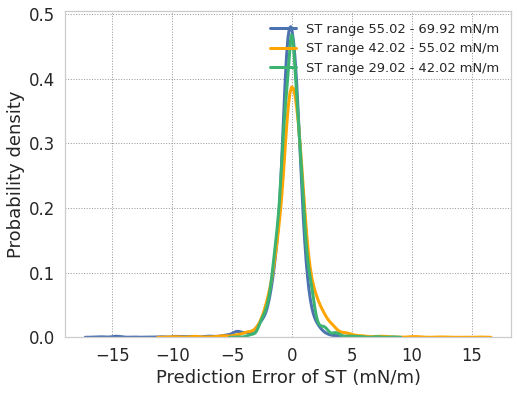

In [ ]:
## Re-scale target feature
def rescaling(target, min=stats.loc['ST']['min'], max=stats.loc['ST']['max']):
  target=np.asarray(target)
  return (max-min)*(target)+min

test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

ST_real_test=rescaling(test_labels)
ST_pred_test=rescaling(test_predictions)

ST_real_train=rescaling(train_labels)
ST_pred_train=rescaling(train_predictions)  



sns.set_theme(style='whitegrid', font_scale=1.5, color_codes=False)

colours='magma_r'


density_scatter(ST_real_test, ST_pred_test, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)



density_scatter(ST_real_train, ST_pred_train, colours=colours)
_ = plt.plot([-100, 100], [-100, 100], '--k')
plt.xlim(25, 75)
plt.ylim(25, 75)


error_test = ST_real_test - ST_pred_test


sns.set_theme(style='whitegrid', font_scale=1.5)

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 76, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.xlim(-3, 3)
plt.tick_params(bottom = False)


plt.figure(figsize=(8,6))
sns.histplot(error_test, bins = 50, kde=True, stat="density")
plt.xlabel("Prediction Error of ST (mN/m)")
_ = plt.ylabel("Probability density")
plt.tick_params(bottom = False)


check_test_df=pd.DataFrame(data={'True_values': ST_real_test, 'Predictions': ST_pred_test})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

step=int((max(sorted_st.True_values)-min(sorted_st.True_values))/3)

trial_1=sorted_st.loc[(sorted_st['True_values'] >= min(sorted_st.True_values)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step))]
trial_2=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step)) & (sorted_st['True_values'] <= (min(sorted_st.True_values)+step*2))]
trial_3=sorted_st.loc[(sorted_st['True_values'] >= (min(sorted_st.True_values)+step*2)) & (sorted_st['True_values'] <= max(sorted_st.True_values))]


thickness=3
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

plt.figure(figsize=(8,6))
sns.distplot(trial_3.Predictions-trial_3.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step*2, max(sorted_st.True_values)))
sns.distplot(trial_2.Predictions-trial_2.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='orange', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values)+step, min(sorted_st.True_values)+step*2))
sns.distplot(trial_1.Predictions-trial_1.True_values, hist=False, kde=True, kde_kws=dict(linewidth=thickness), color='mediumseagreen', label='ST range %.2f - %.2f mN/m' %(min(sorted_st.True_values), min(sorted_st.True_values)+step))
plt.ylabel("Probability density")
plt.xlabel("Prediction Error of ST (mN/m)")
plt.legend(frameon=False, prop={"size":13})
# plt.xlim(-5, 5)





In [ ]:
#Confidence:
error_test_test=np.asarray(error_test)

rows_05=error_test_test[(error_test_test >= -0.5) & (error_test_test <= 0.5)]
rows_1=error_test_test[(error_test_test >= -1) & (error_test_test <= 1)]
rows_2=error_test_test[(error_test_test >= -2) & (error_test_test <= 2)]

print('Confidence for error '+u"\u00B1"+' 0.5 mN/m: %.2f' %int(len(rows_05)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 1 mN/m: %.2f' %int(len(rows_1)/len(error_test)*100)+ ' %')

print('Confidence for error '+u"\u00B1"+' 2 mN/m: %.2f' %int(len(rows_2)/len(error_test)*100)+ ' %')

print('Mean Absolute error: %.2f mN/m' %(sum(abs(error_test_test))/len(error_test_test)))



Confidence for error ± 0.5 mN/m: 43.00 %
Confidence for error ± 1 mN/m: 70.00 %
Confidence for error ± 2 mN/m: 91.00 %
Mean Absolute error: 0.88 mN/m


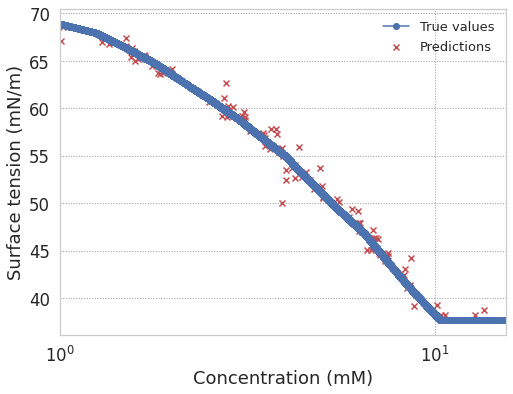

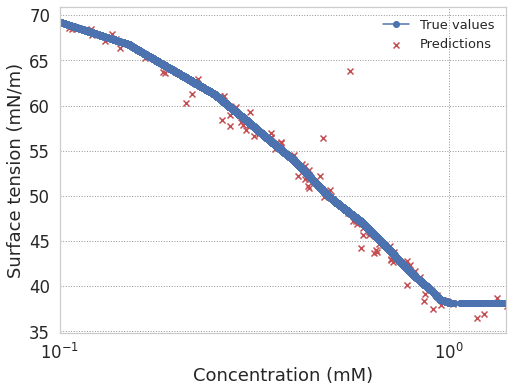

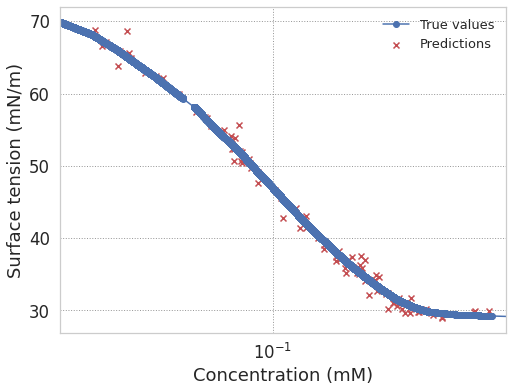

In [ ]:

#Define data-frames with ST, concentration and surfactant number for the dataset + error for the predictions
table_data=pd.DataFrame(np.vstack([training_dataset.ST, surf_conc_train, surf_number_train]).T, columns=['ST', 'surf_conc', 'surf_number'])
table_pred=pd.DataFrame(np.vstack([ST_pred_test, test_dataset.surfactant_conc, error_test, test_dataset.surf_number]).T, columns=['ST_pred', 'conc', 'error', 'surf_number'])

#Sort datasets based on concentration
sorted_data=table_data.sort_values(by=['surf_conc'], ascending=True)
Predictions=table_pred.sort_values(by=['conc'], ascending=True)


#Separate ST and concentration values of each surfactant
data_SDS=sorted_data[sorted_data.surf_number==0]
data_CTAB=sorted_data[sorted_data.surf_number==1]
data_TX100=sorted_data[sorted_data.surf_number==2]


#Separate predictions of each surfactant
pred_SDS=Predictions[Predictions.surf_number==0]
pred_CTAB=Predictions[Predictions.surf_number==1]
pred_TX100=Predictions[Predictions.surf_number==2]

#Randmolly choose n amount of points
seed=5
n=100
plotted_pred_SDS=pred_SDS.sample(n, random_state=seed)
plotted_pred_CTAB=pred_CTAB.sample(n, random_state=seed)
plotted_pred_TX100=pred_TX100.sample(n, random_state=seed)


#Plot isotherm of each surfactant
plt.figure(figsize=(8,6))
plt.semilogx(data_SDS.surf_conc, data_SDS.ST, '-o',  label='True values')
plt.scatter(plotted_pred_SDS.conc, plotted_pred_SDS.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(1, 15.5)
plt.legend(frameon=False, prop={"size":13})


plt.figure(figsize=(8,6))
plt.semilogx(data_CTAB.surf_conc, data_CTAB.ST, '-o', label='True values')
plt.scatter(plotted_pred_CTAB.conc, plotted_pred_CTAB.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.1, 1.4)
plt.legend(frameon=False, prop={"size":13})


plt.figure(figsize=(8,6))
plt.semilogx(data_TX100.surf_conc, data_TX100.ST, '-o',  label='True values')
plt.scatter(plotted_pred_TX100.conc, plotted_pred_TX100.ST_pred, marker='x', color='r', label='Predictions')
plt.xlabel('Concentration (mM)')
plt.ylabel('Surface tension (mN/m)')
plt.xlim(0.015, 0.8)
plt.legend(frameon=False, prop={"size":13})



### Determine the error